Kaggle Competition - COVID 19 week 2: https://www.kaggle.com/c/covid19-global-forecasting-week-2

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/covid19-global-forecasting-week-2/submission.csv
/kaggle/input/covid19-global-forecasting-week-2/test.csv
/kaggle/input/covid19-global-forecasting-week-2/train.csv


In [2]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor

path_train = '../input/covid19-global-forecasting-week-2/train.csv'
path_test = '../input/covid19-global-forecasting-week-2/test.csv'
path_submission = '../input/covid19-global-forecasting-week-2/submission.csv'

covid_train = pd.read_csv(path_train)
covid_test = pd.read_csv(path_test, index_col='ForecastId')
data_submission = pd.read_csv(path_submission, index_col='ForecastId')

In [3]:
def inDay(col):
    '''get new register in day of Confirmed Cases or Fatalities'''
    inDay=[]
    for i in range(len(covid_train)):
        if i==0 or covid_train['Country_Region'][i]!=covid_train['Country_Region'][i-1] or (not pd.isna(covid_train['Province_State'][i]) and not pd.isna(covid_train['Province_State'][i-1]) and covid_train['Province_State'][i]!=covid_train['Province_State'][i-1]) or pd.isna(covid_train['Province_State'][i])!=pd.isna(covid_train['Province_State'][i-1]) :
            inDay.append(covid_train[col][i])
        else:
            inDay.append(covid_train[col][i]-covid_train[col][i-1])
    return pd.DataFrame(inDay)

In [4]:
covid_train['ConfirmedCasesInDay'] = inDay('ConfirmedCases')
covid_train['FatalitiesInDay'] = inDay('Fatalities')

In [5]:
covid_train['Date'] = pd.to_datetime(covid_train['Date'])

In [6]:
covid_train.describe()

,Id,ConfirmedCases,Fatalities,ConfirmedCasesInDay,FatalitiesInDay
count,20580.000000,20580.000000,20580.000000,20580.000000,20580.000000
mean,14685.500000,514.939116,21.080952,41.644752,2.045627
std,8487.230117,4541.261768,287.758197,362.004059,28.061109
min,1.000000,0.000000,0.000000,-62.000000,-5.000000
25%,7335.750000,0.000000,0.000000,0.000000,0.000000
50%,14685.500000,0.000000,0.000000,0.000000,0.000000
75%,22035.250000,35.000000,0.000000,1.000000,0.000000
max,29370.000000,105792.000000,12428.000000,14840.000000,919.000000


Have some Confirmed Cases and Fatilities with the wrong register, that cause 'InDay' less than zero

In [7]:
covid_train[covid_train['FatalitiesInDay']<0].head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities,ConfirmedCasesInDay,FatalitiesInDay
3140,4461,Quebec,Canada,2020-03-22,219.0,4.0,38.0,-1.0
9364,13355,NaN,Iceland,2020-03-16,180.0,0.0,9.0,-5.0
9368,13359,NaN,Iceland,2020-03-20,409.0,0.0,79.0,-1.0
9439,13460,NaN,India,2020-03-21,330.0,4.0,86.0,-1.0
10139,14460,NaN,Kazakhstan,2020-03-21,53.0,0.0,4.0,-3.0


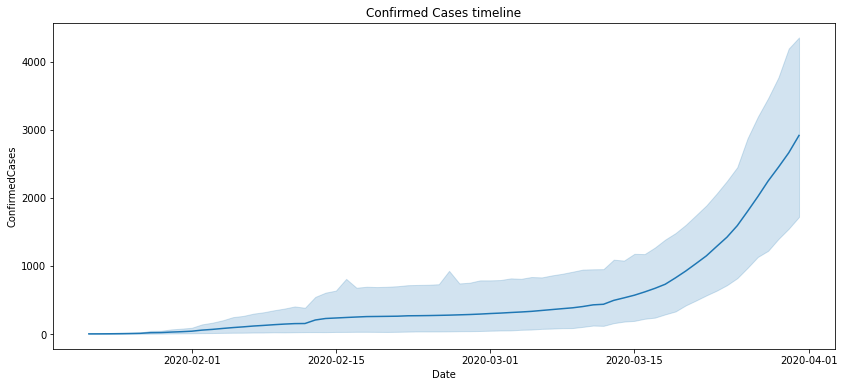

In [8]:
plt.figure(figsize=(14,6))
plt.title('Confirmed Cases timeline')
sns.lineplot(y=covid_train['ConfirmedCases'], x=covid_train['Date'])

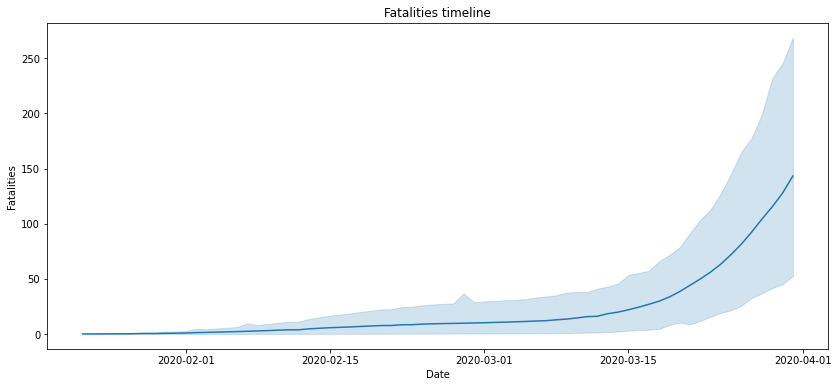

In [9]:
plt.figure(figsize=(14,6))
plt.title('Fatalities timeline')
sns.lineplot(y=covid_train['Fatalities'], x=covid_train['Date'])

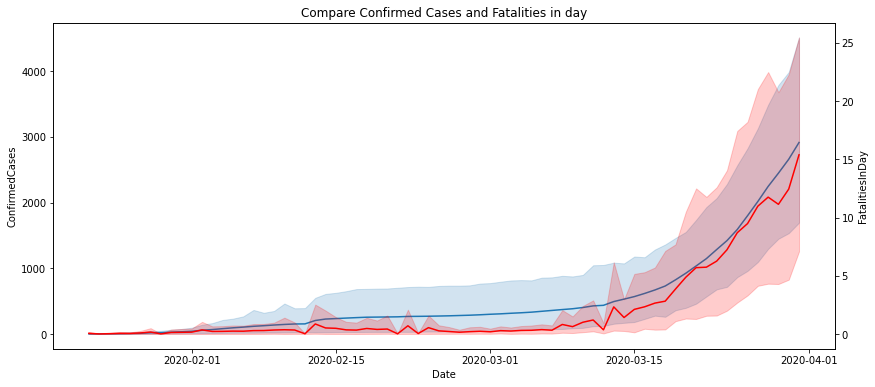

In [10]:
plt.figure(figsize=(14,6))
plt.title('Compare Confirmed Cases and Fatalities in day')
pl = sns.lineplot(y=covid_train['ConfirmedCases'], x=covid_train['Date'])
pl2 = pl.twinx()
sns.lineplot(y=covid_train['FatalitiesInDay'], x=covid_train['Date'], ax=pl2, color="r")

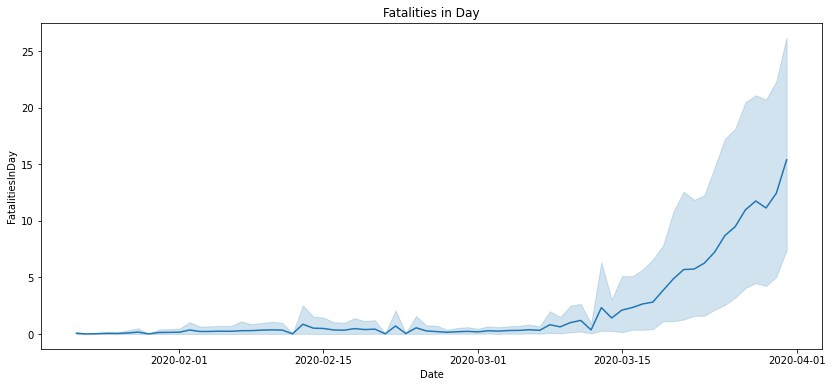

In [11]:
plt.figure(figsize=(14,6))
plt.title('Fatalities in Day')
sns.lineplot(y=covid_train['FatalitiesInDay'], x=covid_train['Date'])

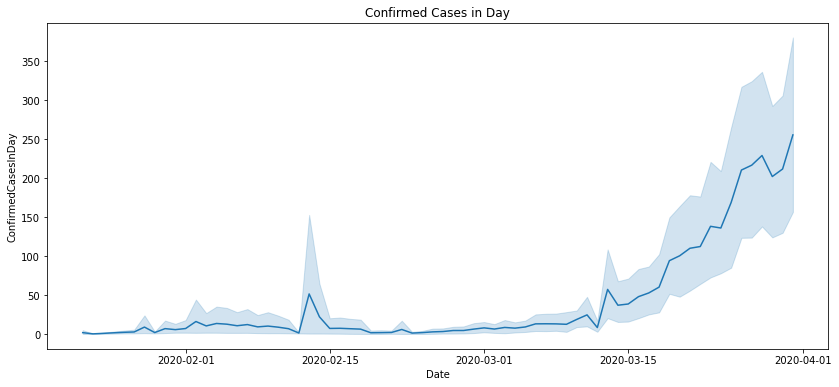

In [12]:
plt.figure(figsize=(14,6))
plt.title('Confirmed Cases in Day')
sns.lineplot(y=covid_train['ConfirmedCasesInDay'], x=covid_train['Date'])

In [13]:
X_features = ['Date', 'Country_Region', 'Province_State']
X = covid_train[X_features]

y_cc = covid_train['ConfirmedCases']
y_ft = covid_train['Fatalities']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, ['Country_Region', 'Province_State'])
    ])

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

cc_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=100, random_state=0))
                             ])

ft_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=100, random_state=0))
                             ])

X_train, X_valid, y_train, y_valid = train_test_split(X, y_cc, random_state=0)
cc_pipeline.fit(X_train, y_train)
preds_cc = cc_pipeline.predict(X_valid).astype(int)

print('MAE to ConfirmedCases:', mean_absolute_error(y_valid, preds_cc))

X_train, X_valid, y_train, y_valid = train_test_split(X, y_ft, random_state=0)
ft_pipeline.fit(X_train, y_train)
preds_ft = ft_pipeline.predict(X_valid).astype(int)

print('MAE to Fatalities:', mean_absolute_error(y_valid, preds_ft))

MAE to ConfirmedCases: 539.9065111758989
MAE to Fatalities: 26.03265306122449


In [15]:
#predict tests
test_preds_cc = cc_pipeline.predict(covid_test[X_features])
test_preds_ft = ft_pipeline.predict(covid_test[X_features])

In [16]:
submission = pd.DataFrame({'ForecastId': covid_test.index,'ConfirmedCases':test_preds_cc,'Fatalities':test_preds_ft})
filename = 'submission.csv'

submission.to_csv(filename,index=False)